Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Similarity Sampler I/O Cookbook

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/sampler_io_cookbook.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/sampler_io_cookbook.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Tensorflow Similarity's Samplers ensure that each batch contains a target number of examples per class per batch. This ensures that the loss functions are able to construct tuples of anchor, positive, and negatives within each batch of examples.

![contrastive_batch.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_batch.png)

In this notebook you will learn how to use the:

* `MultiShotMemorySampler()` for fitting to a sequence of data, such as a dataset.
* `SingleShotMemorySampler()` to treat each example as a seperate class and generate augmented versions within each batch.
* `TFDatasetMultiShotMemorySampler()` to directly integrate with the Tensorflow dataset catalog. 
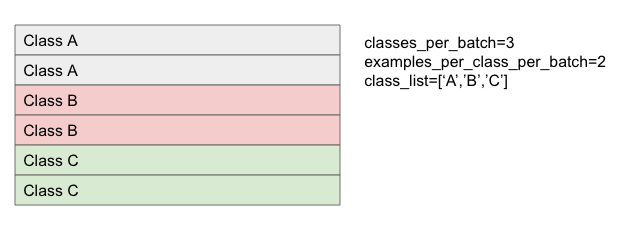

## Imports

In [2]:
import os
import random
from typing import Tuple

import numpy as np
from matplotlib import pyplot as plt

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import tensorflow as tf

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

<hr>

# MultiShotMemorySampler: Load Random Numpy Arrays
The following cell loads random numpy data using TensorFlow similarity`MultiShotMemorySampler()`.

Using a sampler is required to ensure that each batch contains at least N samples for each class included in a batch. 

This batch strucutre is required for the contrastive loss to properly compute positive pairwise distances.

In [6]:
num_ms_examples = 100000  # @param {type:"slider", min:1000, max:1000000}
num_ms_features = 784  # @param {type:"slider", min:10, max:1000}
num_ms_classes = 10  # @param {type:"slider", min:2, max:1000}

# We use random floats here to represent a dense feature vector
X_ms = np.random.rand(num_ms_examples, num_ms_features)
# We use random ints to represent N different classes
y_ms = np.random.randint(low=0, high=10, size=num_ms_examples)

In [7]:
num_known_ms_classes = 5  # @param {type:"slider", min:2, max:1000}
ms_classes_per_batch = num_known_ms_classes
ms_examples_per_class_per_batch = 2  # @param {type:"integer"}
ms_class_list = random.sample(range(num_ms_classes), k=num_known_ms_classes)

ms_sampler = tfsim.samplers.MultiShotMemorySampler(
    X_ms,
    y_ms,
    classes_per_batch=ms_classes_per_batch,
    examples_per_class_per_batch=ms_examples_per_class_per_batch,
    class_list=ms_class_list,
)


The initial batch size is 10 (5 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/100000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/5 [00:00<?, ?it/s]

gather examples:   0%|          | 0/50298 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/50298 [00:00<?, ?it/s]

## Generating Batches
The Tensorflow Similarity memory samplers are a subclass of [tf.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence), overriding the `__getitem__` and `__len__` methods. 

Additionally, Tensorflow Similarity provides a `generate_batch()` method that takes a batch ID and yields a single batch. 

We verify that the batch batch only conatins the classes defined in `CLASS_LIST` and that each class has `ms_classes_per_batch` * `ms_examples_per_class_per_batch` examples. 

In [8]:
X_ms_batch, y_ms_batch = ms_sampler.generate_batch(100)
print("#" * 10 + " X " + "#" * 10)
print(X_ms_batch)
print("\n" + "#" * 10 + " y " + "#" * 10)
print(y_ms_batch)

# Check that the batch size is equal to the target number of classes * target number of examples per class.
assert tf.shape(X_ms_batch)[0] == (ms_classes_per_batch * ms_examples_per_class_per_batch)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_ms_batch)[1] == (num_ms_features)
# Check that classes in the batch are from the allowed set in CLASS_LIST
assert set(tf.unique(y_ms_batch)[0].numpy()) - set(ms_class_list) == set()
# Check that we only have NUM_CLASSES_PER_BATCH
assert len(tf.unique(y_ms_batch)[0]) == ms_classes_per_batch

########## X ##########
tf.Tensor(
[[0.10244997 0.68851606 0.53268052 ... 0.2197804  0.31371643 0.50274743]
 [0.33082377 0.8429225  0.58339878 ... 0.02444365 0.37718794 0.12095115]
 [0.44695482 0.85489889 0.386586   ... 0.51846227 0.66042986 0.25128629]
 ...
 [0.58364963 0.4081118  0.56372653 ... 0.63852515 0.75404133 0.78553425]
 [0.6877641  0.4842029  0.48327635 ... 0.1334299  0.58277972 0.33514591]
 [0.18217164 0.2938196  0.59372672 ... 0.78299004 0.32033609 0.55217744]], shape=(10, 784), dtype=float64)

########## y ##########
tf.Tensor([7 7 3 3 2 2 8 8 9 9], shape=(10,), dtype=int64)


## Sampler Sizes

`MultiShotMemorySampler()` provides various attributes for accessing info about the data:
* `__len__` provides the number of steps per epoch. 
* `num_examples` provides the total number of examples within the sampler.
* `example_shape` provides the shape of the examples.

The `num_examples` attribute represents the subset of X and y where y is in the `class_list` with each class limited to `num_examples_per_class`.

In [9]:
print(f"The sampler contains {len(ms_sampler)} steps per epoch.")
print(f"The sampler is using {ms_sampler.num_examples} examples out of the original {num_ms_examples}.")
print(f"Each examples has the following shape: {ms_sampler.example_shape}.")

The sampler contains 1000 steps per epoch.
The sampler is using 50298 examples out of the original 100000.
Each examples has the following shape: (784,).


## Accessing the Examples

Additionaly, the `MultiShotMemorySampler()` provides `get_slice()` for manually accessing examples within the Sampler.

**NOTE**: the examples are shuffled when creating the Sampler but will yield the same examples for each call to get_slice(begin, size).

In [10]:
# Get 10 examples starting at example 200.
X_ms_slice, y_ms_slice = ms_sampler.get_slice(begin=200, size=10)
print("#" * 10 + " X " + "#" * 10)
print(X_ms_slice)
print("\n" + "#" * 10 + " y " + "#" * 10)
print(y_ms_slice)

# Check that the batch size is equal to our get_slice size.
assert tf.shape(X_ms_slice)[0] == 10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_ms_slice)[1] == (num_ms_features)
# Check that classes in the batch are from the allowed set in CLASS_LIST
assert set(tf.unique(y_ms_slice)[0].numpy()) - set(ms_class_list) == set()

########## X ##########
tf.Tensor(
[[0.67971507 0.74731585 0.7144337  ... 0.07861843 0.29287101 0.04500069]
 [0.84780348 0.85496437 0.44088087 ... 0.57199698 0.99068429 0.78402967]
 [0.76641663 0.23609457 0.43546836 ... 0.84303339 0.86315334 0.07298692]
 ...
 [0.25578582 0.38847316 0.24466354 ... 0.26129626 0.5394666  0.31837792]
 [0.0643712  0.75872309 0.29096849 ... 0.3019719  0.8388412  0.80194445]
 [0.24814494 0.17823982 0.41733159 ... 0.32008895 0.14422262 0.6962133 ]], shape=(10, 784), dtype=float64)

########## y ##########
tf.Tensor([9 7 2 3 7 2 7 9 2 9], shape=(10,), dtype=int64)


<hr>

# SingleShotMemorySampler: Augmented MNIST Examples

The following cell loads and augments MNIST examples using the `SingleShotMemorySampler()`.

The Sampler treats each example as it's own class and adds augmented versions of each image to the batch.

This means the final batch size is the number of `examples per batch * (1 + the number of augmentations)`.

In [11]:
(aug_x, _), _ = tf.keras.datasets.mnist.load_data()
# Normalize the image data.
aug_x = tf.cast(aug_x / 255.0, dtype="float32")

In [12]:
aug_num_examples_per_batch = 18  # @param {type:"slider", min:18, max:512}
aug_num_augmentations_per_example = 1  # @param {type:"slider", min:1, max:3}

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.12),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.25),
    ]
)


def augmenter(
    x: tfsim.types.FloatTensor, y: tfsim.types.IntTensor, examples_per_class: int, is_warmup: bool, stddev=0.025
) -> Tuple[tfsim.types.FloatTensor, tfsim.types.IntTensor]:
    """Image augmentation function.

    Args:
        X: FloatTensor representing the example features.
        y: IntTensor representing the class id. In this case
           the example index will be used as the class id.
        examples_per_class: The number of examples per class.
           Not used here.
        is_warmup: If True, the training is still in a warm
           up state. Not used here.
        stddev: Sets the amount of gaussian noise added to
           the image.
    """
    _ = examples_per_class
    _ = is_warmup

    aug = tf.squeeze(data_augmentation(tf.expand_dims(x, -1)))
    aug = aug + tf.random.normal(tf.shape(aug), stddev=stddev)
    x = tf.concat((x, aug), axis=0)
    y = tf.concat((y, y), axis=0)
    idxs = tf.range(start=0, limit=tf.shape(x)[0])
    idxs = tf.random.shuffle(idxs)
    x = tf.gather(x, idxs)
    y = tf.gather(y, idxs)
    return x, y


aug_sampler = tfsim.samplers.SingleShotMemorySampler(
    aug_x,
    augmenter=augmenter,
    examples_per_batch=aug_num_examples_per_batch,
    num_augmentations_per_example=aug_num_augmentations_per_example,
)


The initial batch size is 18 (18 classes * 1 examples per class) with 1 augmenters


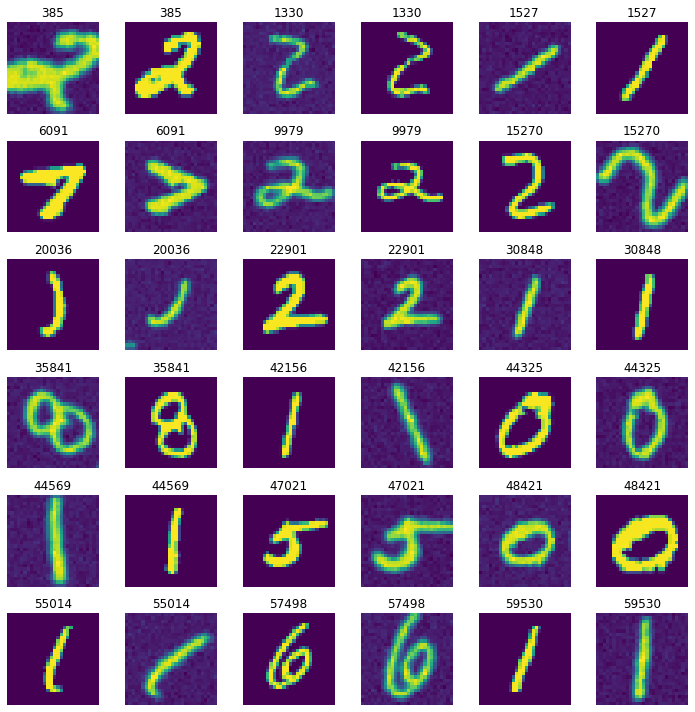

In [13]:
# Plot the first 36 examples
num_imgs = 36
num_row = num_col = 6
aug_batch_x, aug_batch_y = aug_sampler[0]
# Sort the class ids so we can see the original
# and augmented versions as pairs.
sorted_idx = np.argsort(aug_batch_y)
plt.figure(figsize=(10, 10))
for i in range(num_imgs):
    idx = sorted_idx[i]
    ax = plt.subplot(num_row, num_col, i + 1)
    plt.imshow(aug_batch_x[idx])
    plt.title(int(aug_batch_y[idx]))
    plt.axis("off")

plt.tight_layout()

## Sampler Sizes

`SingleShotMemorySampler()` provides various attributes for accessing info about the data:
* `__len__` provides the number of steps per epoch. 
* `num_examples` provides the number of examples within the sampler.
* `example_shape` provides the shape of the examples.

The `num_examples` attribute represents the unaugmented examples within the sampler.

In [14]:
print(f"The sampler contains {len(aug_sampler)} steps per epoch.")
print(f"The sampler is using {aug_sampler.num_examples} examples out of the original {len(aug_x)}.")
print(f"Each examples has the following shape: {aug_sampler.example_shape}.")

The sampler contains 1000 steps per epoch.
The sampler is using 60000 examples out of the original 60000.
Each examples has the following shape: (28, 28).


## Accessing the Examples

Additionaly, the `SingleShotMemorySampler()` provides `get_slice()` for manually accessing examples within the Sampler.

The method returns slice size plus the augmented examples returned by the augmenter function.

In [15]:
# Get 10 examples starting at example 200.
X_aug_slice, y_aug_slice = aug_sampler.get_slice(begin=200, size=10)
print("#" * 10 + " X " + "#" * 10)
print(tf.reshape(X_aug_slice, (10, -1)))
print("\n" + "#" * 10 + " y " + "#" * 10)
print(y_aug_slice)

# Check that the batch size is double our get_slice size (original examples + augmented examples).
assert tf.shape(X_aug_slice)[0] == 10 + 10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_aug_slice)[1] == (28)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_aug_slice)[2] == (28)

########## X ##########
tf.Tensor(
[[-0.00997978  0.00617402  0.01313185 ...  0.          0.
   0.        ]
 [ 0.02951331 -0.03293552 -0.04664254 ...  0.01396393  0.04904613
  -0.03245329]
 [ 0.          0.          0.         ... -0.00042304  0.01749511
   0.01238921]
 ...
 [ 0.          0.          0.         ...  0.04047115 -0.02581433
  -0.01545236]
 [-0.01065458 -0.04568783 -0.01707101 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.00545302  0.00376998
   0.00757402]], shape=(10, 1568), dtype=float32)

########## y ##########
tf.Tensor(
[202 203 200 204 205 201 206 206 202 204 207 203 209 201 208 208 209 200
 207 205], shape=(20,), dtype=int32)


<hr>

# TFDatasetMultiShotMemorySampler: Load data from TF Dataset
The following cell loads data directly from the TensorFlow catalog using TensorFlow similarity
`TFDatasetMultiShotMemorySampler()`. 

Using a sampler is required to ensure that each batch contains at least N samples of each class incuded in a batch. Otherwise the contrastive loss does not work properly as it can't compute positive distances.

In [16]:
IMG_SIZE = 300  # @param {type:"integer"}

# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label):
    with tf.device("/cpu:0"):
        img = tf.cast(img, dtype="int32")
        img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
        return img, label

In [17]:
training_classes = 16  # @param {type:"slider", min:1, max:37}
tfds_examples_per_class_per_batch = 4  # @param {type:"integer"}
tfds_class_list = random.sample(range(37), k=training_classes)
tfds_classes_per_batch = max(16, training_classes)

print(f"Class IDs seen during training {tfds_class_list}\n")

# use the train split for training
print("#" * 10 + " Train Sampler " + "#" * 10)
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "oxford_iiit_pet",
    splits="train",
    examples_per_class_per_batch=tfds_examples_per_class_per_batch,
    classes_per_batch=tfds_classes_per_batch,
    preprocess_fn=resize,
    class_list=tfds_class_list,
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
print("\n" + "#" * 10 + " Test Sampler " + "#" * 10)
test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "oxford_iiit_pet", splits="test", total_examples_per_class=20, classes_per_batch=tfds_classes_per_batch, preprocess_fn=resize
)

Class IDs seen during training [25, 30, 11, 12, 28, 4, 10, 34, 6, 20, 18, 17, 35, 36, 23, 1]

########## Train Sampler ##########


converting train:   0%|          | 0/3680 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Preprocessing data:   0%|          | 0/3680 [00:00<?, ?it/s]


The initial batch size is 64 (16 classes * 4 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/3680 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/16 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1589 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1589 [00:00<?, ?it/s]


########## Test Sampler ##########


converting test:   0%|          | 0/3669 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/3669 [00:00<?, ?it/s]


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/3669 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/37 [00:00<?, ?it/s]

gather examples:   0%|          | 0/740 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/740 [00:00<?, ?it/s]

## Generating Batches
The Tensorflow Similarity memory samplers are a subclass of [tf.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence), overriding the `__getitem__` and `__len__` methods. 

Additionally, Tensorflow Similarity provides a `generate_batch()` method that takes a batch ID and yields a single batch. 

We verify that the batch batch only conatins the classes defined in `CLASS_LIST` and that each class has `tfds_classes_per_batch` * `tfds_examples_per_class_per_batch` examples. 

In [18]:
X_tfds_batch, y_tfds_batch = train_ds.generate_batch(100)
print("#" * 10 + " X " + "#" * 10)
print(f"Actual Tensor Shape {X_tfds_batch.shape}")
print(tf.reshape(X_tfds_batch, (len(X_tfds_batch), -1)))
print("\n" + "#" * 10 + " y " + "#" * 10)
print(y_tfds_batch)

# Check that the batch size is equal to the target number of classes * target number of examples per class.
assert tf.shape(X_tfds_batch)[0] == (tfds_classes_per_batch * tfds_examples_per_class_per_batch)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_batch)[1] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_batch)[2] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_batch)[3] == (3)
# Check that classes in the batch are from the allowed set in CLASS_LIST
assert set(tf.unique(y_tfds_batch)[0].numpy()) - set(tfds_class_list) == set()
# Check that we only have NUM_CLASSES_PER_BATCH
assert len(tf.unique(y_tfds_batch)[0]) == tfds_classes_per_batch

########## X ##########
Actual Tensor Shape (64, 300, 300, 3)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 270000), dtype=float32)

########## y ##########
tf.Tensor(
[ 4  4  4  4  6  6  6  6 23 23 23 23 18 18 18 18 17 17 17 17 30 30 30 30
 35 35 35 35 10 10 10 10 28 28 28 28 12 12 12 12  1  1  1  1 25 25 25 25
 36 36 36 36 20 20 20 20 34 34 34 34 11 11 11 11], shape=(64,), dtype=int64)


## Sampler Sizes

`TFDatasetMultiShotMemorySampler()` provides various attributes for accessing info about the data:
* `__len__` provides the number of steps per epoch. 
* `num_examples` provides the number of examples within the sampler.
* `example_shape` provides the shape of the examples.

In [19]:
print(f"The Train sampler contains {len(train_ds)} steps per epoch.")
print(f"The Train sampler is using {train_ds.num_examples} examples.")
print(f"Each examples has the following shape: {train_ds.example_shape}.")

The Train sampler contains 1000 steps per epoch.
The Train sampler is using 1589 examples.
Each examples has the following shape: (300, 300, 3).


In [20]:
print(f"The Test sampler contains {len(test_ds)} steps per epoch.")
print(f"The Test sampler is using {test_ds.num_examples} examples.")
print(f"Each examples has the following shape: {test_ds.example_shape}.")

The Test sampler contains 1000 steps per epoch.
The Test sampler is using 740 examples.
Each examples has the following shape: (300, 300, 3).


## Accessing the Examples

Additionaly, the `SingleShotMemorySampler()` provides `get_slice()` for manually accessing examples within the Sampler.

The method returns slice size plus the augmented examples returned by the augmenter function.

In [21]:
# Get 10 examples starting at example 200.
X_tfds_slice, y_tfds_slice = train_ds.get_slice(begin=200, size=10)
print("#" * 10 + " X " + "#" * 10)
print(f"Actual Tensor Shape {X_tfds_slice.shape}")
print(tf.reshape(X_tfds_slice, (len(X_tfds_slice), -1)))
print("\n" + "#" * 10 + " y " + "#" * 10)
print(y_tfds_slice)

# Check that the batch size.
assert tf.shape(X_tfds_slice)[0] == 10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[1] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[2] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[3] == (3)

########## X ##########
Actual Tensor Shape (10, 300, 300, 3)
tf.Tensor(
[[  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 ...
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [153.33334 151.33334 153.22223 ... 174.00002 174.5556  166.44449]], shape=(10, 270000), dtype=float32)

########## y ##########
[28 20 17  4  1 28 17 20 35 23]


In [22]:
# Get 10 examples starting at example 200.
X_tfds_slice, y_tfds_slice = test_ds.get_slice(begin=200, size=10)
print("#" * 10 + " X " + "#" * 10)
print(f"Actual Tensor Shape {X_tfds_slice.shape}")
print(tf.reshape(X_tfds_slice, (len(X_tfds_slice), -1)))
print("\n" + "#" * 10 + " y " + "#" * 10)
print(y_tfds_slice)

# Check that the batch size.
assert tf.shape(X_tfds_slice)[0] == 10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[1] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[2] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[3] == (3)

########## X ##########
Actual Tensor Shape (10, 300, 300, 3)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10, 270000), dtype=float32)

########## y ##########
[24 19  9  7  1 13  9 20 25 17]
